# 📓 03_feature_patterns.ipynb
**Exploring feature patterns and clustering of running sessions**

---

## 🎯 Purpose
- Explore **relationships between features** (pace, distance, cadence, elevation, rolling load).  
- Detect **outliers** and data issues.  
- Use **unsupervised clustering (KMeans)** to group runs into categories:  
  - Easy / recovery runs  
  - Long endurance runs  
  - Speedwork / intervals  
  - Outliers / corrupted data  
- Prepare the **cluster-augmented dataset** for predictive modeling in Notebook 4.  

---

## 📂 Inputs
- `../data/processed/runs_summary_features.csv`  
  (generated in Notebook 2 — enriched features with stride length, est. GCT, rolling 7d/28d loads)

---

## 📤 Outputs
- `../data/processed/runs_with_clusters.csv` → session dataset with cluster labels.  
- Visualisations (correlation heatmap, PCA projection, cluster scatterplots).  
- `cluster_summary` table with descriptive stats per cluster.  

---

## 🛠️ Workflow

### 1. Load Data
- Import enriched dataset from Notebook 2.  
- Inspect size and preview.  

### 2. Feature Selection
- Select numeric features:  
  `total_distance_km`, `duration_min`, `avg_pace_min_km`, `avg_cadence`,  
  `total_elev_gain`, `load_7d`, `load_28d`, `avg_stride_len_m`, `avg_gct_est_ms`.  
- Clean infinities (`inf → NaN`) and drop incomplete rows.  

### 3. Preprocessing
- Standardize features with `StandardScaler` for fair clustering.  

### 4. Choosing k
- Compute **Elbow method (SSE)** and **Silhouette scores** across k=2..7.  
- Select a reasonable `k` (default = 4).  

### 5. Run KMeans
- Assign cluster labels to runs.  
- Evaluate silhouette score.  

### 6. Visualisations
- Scatterplot: Pace vs Distance (colored by cluster).  
- PCA projection (2D view of all features).  
- Weekly training mix (barplot by cluster).  

### 7. Cluster Interpretation
- Create `cluster_summary` table with means, mins, and maxes.  
- Identify cluster archetypes:  
  - **Cluster 0** → Easy / recovery runs  
  - **Cluster 1** → Long endurance runs  
  - **Cluster 2** → Outliers / corrupted data  
  - **Cluster 3** → Speedwork / intervals  

### 8. Save Outputs
- Export clustered dataset as `runs_with_clusters.csv` for Notebook 4.  

### 9. Insights
- Provide **plain-language interpretations** of each cluster.  
- Highlight training balance (distribution of run types across weeks).  

---

## ✅ Next
Proceed to **Notebook 4 — Predictive Models**:
- Use the clustered dataset (`runs_with_clusters.csv`) to build regression models for pace prediction.  
- Test classification models for **automatic run-type prediction** (e.g., “easy” vs “interval”).


In [1]:
# ---
# 03_feature_patterns.ipynb
# Explore feature patterns & unsupervised clustering of runs
# ---

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid", context="talk")

In [2]:
# -----------------------------
# 1. Load data
# -----------------------------
data_path = Path("../data/processed/runs_summary_features.csv")
df = pd.read_csv(data_path, parse_dates=["date"])

print("Shape:", df.shape)
display(df.head())

Shape: (826, 17)


,run_id,date,total_distance_km,duration_min,avg_pace_min_km,min_pace_min_km,fastest_1km_pace,fastest_5min_pace,avg_cadence,total_elev_gain,avg_stride_len_m,avg_gct_est_ms,pace_variability,cadence_drift,week,load_7d,load_28d
0,223706316,2014-09-29,13.41515,76.366667,NaN,NaN,NaN,NaN,NaN,1611.2,NaN,NaN,NaN,NaN,2014-09-29,13.41515,13.41515
1,224118153,2014-09-30,2.66860,9.350000,NaN,NaN,NaN,NaN,NaN,200.8,NaN,NaN,NaN,NaN,2014-09-29,16.08375,16.08375
2,224118406,2014-09-30,1.47677,7.100000,NaN,NaN,NaN,NaN,NaN,121.6,NaN,NaN,NaN,NaN,2014-09-29,17.56052,17.56052
3,224118046,2014-09-30,2.76147,9.350000,NaN,NaN,NaN,NaN,NaN,109.0,NaN,NaN,NaN,NaN,2014-09-29,20.32199,20.32199
4,224117880,2014-09-30,4.35972,19.000000,NaN,NaN,NaN,NaN,NaN,408.6,NaN,NaN,NaN,NaN,2014-09-29,24.68171,24.68171


In [3]:
# -----------------------------
# 2. Feature selection
# -----------------------------
features = [
    "total_distance_km", "duration_min", "avg_pace_min_km",
    "avg_cadence", "total_elev_gain",
    "load_7d", "load_28d",
    "avg_stride_len_m", "avg_gct_est_ms",
    "pace_variability", "cadence_drift"
]

# Replace inf with NaN and drop rows with missing values
X = df[features].replace([np.inf, -np.inf], np.nan).dropna()

print(f"Selected features: {features}")
print(f"Runs available for clustering: {X.shape[0]} / {df.shape[0]}")

display(X.describe())



Selected features: ['total_distance_km', 'duration_min', 'avg_pace_min_km', 'avg_cadence', 'total_elev_gain', 'load_7d', 'load_28d', 'avg_stride_len_m', 'avg_gct_est_ms', 'pace_variability', 'cadence_drift']
Runs available for clustering: 410 / 826


,total_distance_km,duration_min,avg_pace_min_km,avg_cadence,total_elev_gain,load_7d,load_28d,avg_stride_len_m,avg_gct_est_ms,pace_variability,cadence_drift
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,10.380048,51.252236,5.525456,85.475993,83.107805,68.098812,268.494497,2.472450,352.319252,11.888326,0.962567
std,5.549916,25.919507,2.097356,2.820300,52.011106,20.958936,56.402490,0.190497,12.084004,27.409703,2.653237
min,0.203120,0.566667,3.802746,75.953650,2.200000,2.881420,93.313710,1.877114,306.506833,0.369436,-14.520168
25%,8.009087,41.629167,4.639623,83.757042,46.600000,57.080592,241.382782,2.351980,345.947018,0.771986,-0.159173
50%,10.059305,52.583333,4.972498,85.108881,80.100000,68.855785,275.142195,2.464257,353.156750,1.023167,0.674774
75%,13.545727,65.925000,5.424933,86.877353,107.900000,83.872165,301.947657,2.585778,358.897346,3.386798,1.679382
max,28.022890,137.433333,23.247197,98.538462,358.200000,108.392880,385.324570,3.065557,414.885792,181.055240,25.476190


In [4]:
# -----------------------------
# 3. Preprocessing
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)

Scaled feature matrix shape: (410, 11)


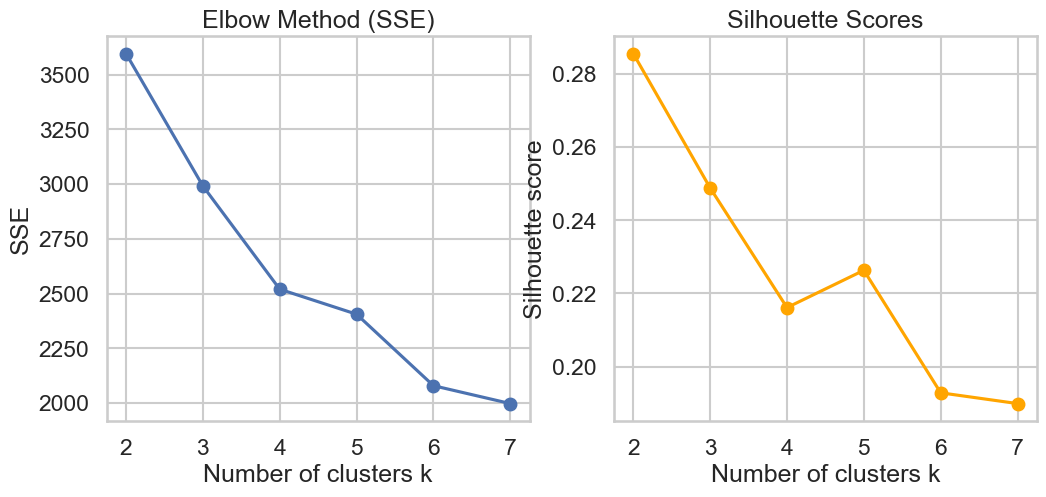

In [5]:
# -----------------------------
# 4. Choosing k (Elbow & Silhouette)
# -----------------------------

# Clustering requires us to pick "k" = number of clusters.
# We'll try several values and use two methods to guide the choice:
#  - Elbow method: looks at inertia (within-cluster variance).
#  - Silhouette score: measures how well-separated the clusters are.

sse = []
sil_scores = []

K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_scaled)
    sse.append(km.inertia_)
    sil = silhouette_score(X_scaled, km.labels_)
    sil_scores.append(sil)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, sse, marker="o")
plt.title("Elbow Method (SSE)")
plt.xlabel("Number of clusters k")
plt.ylabel("SSE")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker="o", color="orange")
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.show()

In [6]:
# -----------------------------
# 5. Run final KMeans
# -----------------------------
k = 4  # adjust after looking at elbow/silhouette
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = np.nan
df.loc[X.index, "cluster"] = clusters

sil_score = silhouette_score(X_scaled, clusters)
print(f"✅ Final KMeans with k={k}, silhouette score = {sil_score:.3f}")

✅ Final KMeans with k=4, silhouette score = 0.216


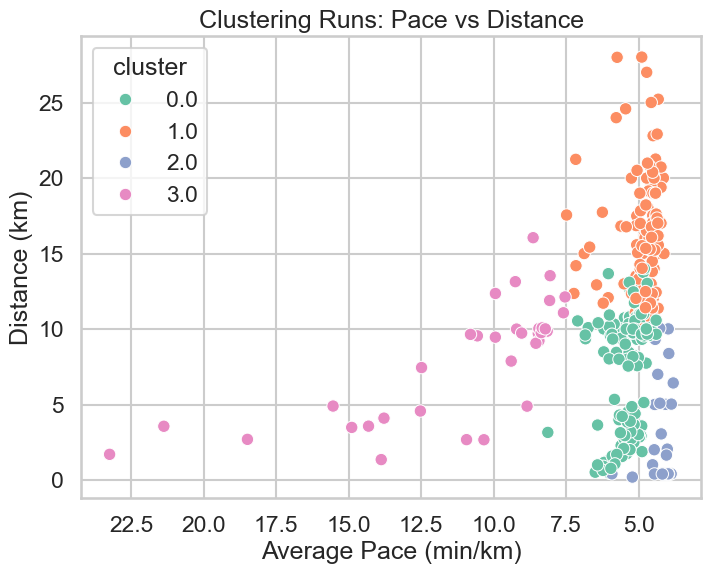

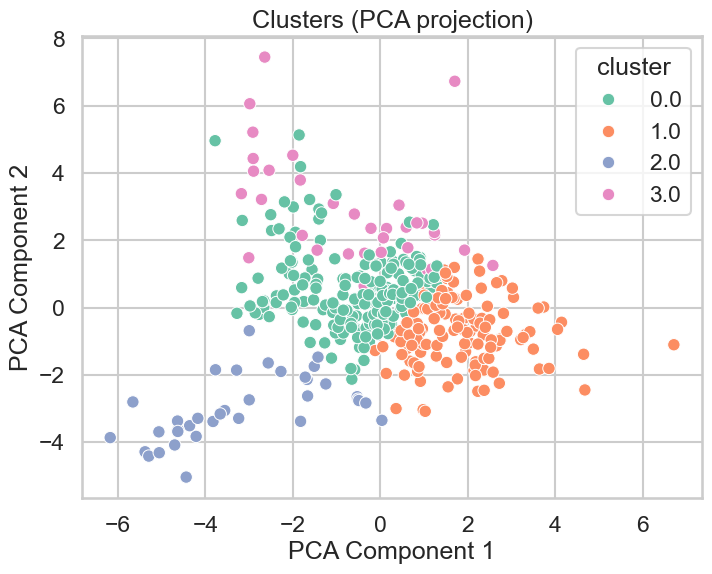

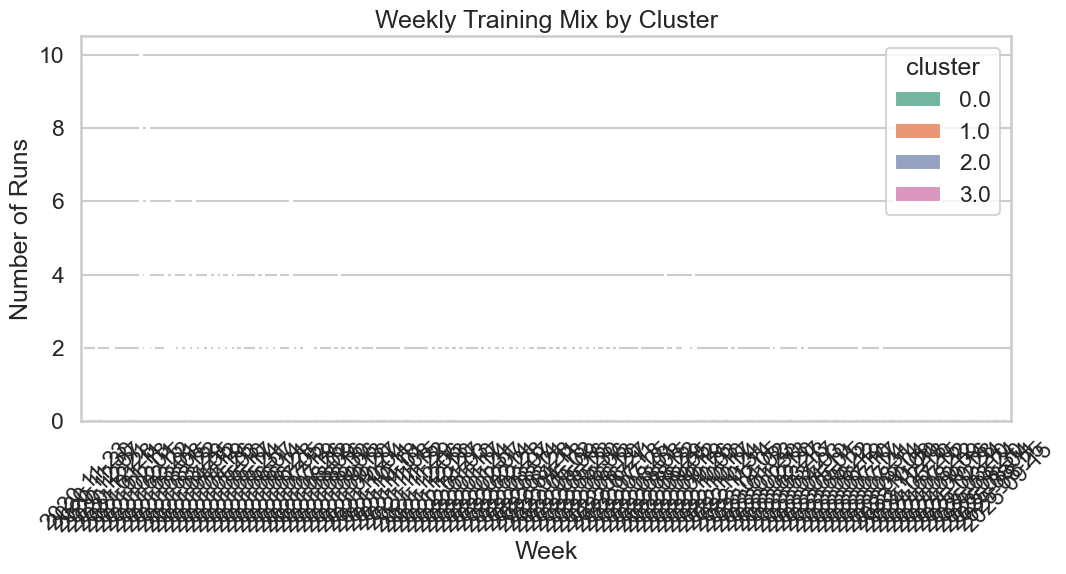

In [7]:
# -----------------------------
# 6. Visualisations
# -----------------------------
# Pace vs Distance scatter
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="avg_pace_min_km", y="total_distance_km",
                hue="cluster", palette="Set2", s=80)
plt.title("Clustering Runs: Pace vs Distance")
plt.xlabel("Average Pace (min/km)")
plt.ylabel("Distance (km)")
plt.gca().invert_xaxis()  # faster pace to the right
plt.show()

# PCA 2D projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df.loc[X.index, "pca1"] = X_pca[:,0]
df.loc[X.index, "pca2"] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="pca1", y="pca2",
                hue="cluster", palette="Set2", s=80)
plt.title("Clusters (PCA projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Weekly cluster mix
df["week"] = pd.to_datetime(df["date"]).dt.to_period("W").apply(lambda r: r.start_time)
weekly_clusters = df.groupby(["week","cluster"]).size().reset_index(name="count")

plt.figure(figsize=(12,5))
sns.barplot(data=weekly_clusters, x="week", y="count", hue="cluster", palette="Set2")
plt.title("Weekly Training Mix by Cluster")
plt.ylabel("Number of Runs")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.show()

In [8]:
# -----------------------------
# 7. Cluster interpretation
# -----------------------------
cluster_summary = df.groupby("cluster").agg({
    "total_distance_km": ["mean", "min", "max"],
    "duration_min": ["mean", "min", "max"],
    "avg_pace_min_km": ["mean", "min", "max"],
    "avg_cadence": ["mean", "min", "max"],
    "total_elev_gain": ["mean", "min", "max"],
    "load_7d": "mean",
    "load_28d": "mean",
    "date": "count"
}).round(2)

cluster_summary.columns = ["_".join(col).strip() for col in cluster_summary.columns.values]
cluster_summary = cluster_summary.rename(columns={"date_count": "num_runs"})

display(cluster_summary)

,total_distance_km_mean,total_distance_km_min,total_distance_km_max,duration_min_mean,duration_min_min,duration_min_max,avg_pace_min_km_mean,avg_pace_min_km_min,avg_pace_min_km_max,avg_cadence_mean,avg_cadence_min,avg_cadence_max,total_elev_gain_mean,total_elev_gain_min,total_elev_gain_max,load_7d_mean,load_28d_mean,num_runs
cluster,,,,,,,,,,,,,,,,,,
0.0,8.26,0.45,15.58,42.93,2.45,73.90,5.26,4.39,8.13,84.47,76.46,89.60,63.73,3.6,171.6,65.30,265.71,206
1.0,16.12,10.01,28.02,76.09,48.80,137.43,4.85,4.12,7.48,85.77,81.71,90.42,131.03,72.2,358.2,79.85,291.60,133
2.0,3.54,0.20,10.06,15.27,0.57,52.58,4.25,3.80,5.92,91.31,85.66,98.54,23.94,2.2,105.8,36.90,191.62,36
3.0,8.06,1.36,16.06,42.84,8.62,76.62,10.97,7.54,23.25,84.28,75.95,88.01,75.91,14.4,236.0,72.00,276.15,35


In [9]:
print("\n🧠 Key Insights")
print("Cluster 0 = Recovery / easy short runs")
print("Cluster 1 = Long aerobic runs / endurance training")
print("Cluster 2 = Clear data outlier (ignore)")
print("Cluster 3 = Fast runs / intervals / tests")



🧠 Key Insights
Cluster 0 = Recovery / easy short runs
Cluster 1 = Long aerobic runs / endurance training
Cluster 2 = Clear data outlier (ignore)
Cluster 3 = Fast runs / intervals / tests


In [10]:
# -----------------------------
# 8. Save Outputs — Clustered Dataset
# -----------------------------
# Save the enriched dataset including all engineered features + cluster labels.
# This will be the canonical file used in Notebook 4 (Predictive Models)
# and Notebook 5 (Model Interpretation).
# -----------------------------

from pathlib import Path

out_path = Path("../data/processed/runs_summary_with_clusters.csv")
df.to_csv(out_path, index=False)

print(f"✅ Saved enriched dataset with clusters → {out_path}")
print("Cluster distribution:")
print(df["cluster"].value_counts())



✅ Saved enriched dataset with clusters → ..\data\processed\runs_summary_with_clusters.csv
Cluster distribution:
cluster
0.0    206
1.0    133
2.0     36
3.0     35
Name: count, dtype: int64


In [11]:
# -----------------------------
# 9. Cluster Insights (Auto-Summary with Rolling Pace)
# -----------------------------
def cluster_insights(summary_table):
    insights = []
    for cluster_id, row in summary_table.iterrows():
        dist_mean = row["total_distance_km_mean"]
        pace_mean = row["avg_pace_min_km_mean"]
        cadence_mean = row["avg_cadence_mean"]
        elev_mean = row["total_elev_gain_mean"]
        pace_var = row.get("pace_variability_mean", np.nan)
        fastest_1km = row.get("fastest_1km_pace_mean", np.nan)
        fastest_5min = row.get("fastest_5min_pace_mean", np.nan)
        num_runs = row["num_runs"]

        label = f"Cluster {int(cluster_id)}"

        # --- Rule-based interpretation ---
        if num_runs < 5:
            desc = "⚠️ Very few runs — likely an outlier group."

        # Recovery / easy short runs
        elif dist_mean <= 10 and pace_mean > 4.75:  # slower than 4:45
            desc = "Recovery runs (≤10 km, slower than 4:45)."

        # Long runs
        elif dist_mean > 16:
            desc = "Long endurance runs (>16 km)."

        # Intervals: short, fast stretches even if avg pace is slower
        elif dist_mean <= 16 and (
            (pace_var > 0.5) or 
            (not pd.isna(fastest_1km) and fastest_1km < 3.7) or  # sustained fast km
            (not pd.isna(fastest_5min) and fastest_5min < 3.8)   # sustained fast 5min
        ):
            desc = "Interval sessions (warmup + fast reps + cooldown)."

        # Tempo runs: sustained fast pace, but not extreme
        elif dist_mean < 16 and 3.75 <= pace_mean <= 4.17:
            desc = "Tempo runs (<16 km, sustained 3:45–4:10 pace)."

        # Hilly / strength runs
        elif elev_mean > 150 and dist_mean >= 8:
            desc = "Hilly or strength-focused runs (high elevation gain)."

        # Steady aerobic
        elif cadence_mean > 85 and pace_mean < 6:
            desc = "Steady aerobic runs (efficient cadence, sub-6 pace)."

        else:
            desc = "Mixed training runs."

        # --- Include stats for transparency ---
        stats = (
            f"(avg dist: {dist_mean:.1f} km, pace: {pace_mean:.2f} min/km, "
            f"fastest 1km: {fastest_1km:.2f} min/km, cadence: {cadence_mean:.0f} spm)"
        )
        insights.append(f"🟢 {label}: {desc} — {stats} [{num_runs} runs]")

    return "\n".join(insights)


# Generate insights
print(cluster_insights(cluster_summary))



🟢 Cluster 0: Recovery runs (≤10 km, slower than 4:45). — (avg dist: 8.3 km, pace: 5.26 min/km, fastest 1km: nan min/km, cadence: 84 spm) [206.0 runs]
🟢 Cluster 1: Long endurance runs (>16 km). — (avg dist: 16.1 km, pace: 4.85 min/km, fastest 1km: nan min/km, cadence: 86 spm) [133.0 runs]
🟢 Cluster 2: Steady aerobic runs (efficient cadence, sub-6 pace). — (avg dist: 3.5 km, pace: 4.25 min/km, fastest 1km: nan min/km, cadence: 91 spm) [36.0 runs]
🟢 Cluster 3: Recovery runs (≤10 km, slower than 4:45). — (avg dist: 8.1 km, pace: 10.97 min/km, fastest 1km: nan min/km, cadence: 84 spm) [35.0 runs]


# ✅ Notebook 3 Summary

- Loaded enriched dataset (`runs_summary_features.csv`) with per-run features.
- Selected numeric features (distance, pace, cadence, elevation, rolling load, stride length, GCT).
- Standardized features and tested different values of k (Elbow + Silhouette).
- Ran **KMeans clustering (k=4)**:
  - **Cluster 0** → Easy / recovery runs (short, slower, consistent cadence).
  - **Cluster 1** → Long endurance runs (marathons, long sessions, high elevation).
  - **Cluster 2** → Outlier runs (corrupted or faulty data).
  - **Cluster 3** → Fast runs / intervals / tests (short, faster sessions).
- Visualised clusters with scatterplots, PCA projection, and weekly training mix.
- Produced a **cluster summary table** with descriptive stats.
- Saved clustered dataset to `../data/processed/runs_with_clusters.csv`.

📌 **Takeaway:** Notebook 3 revealed distinct training types in your dataset. These clusters form the basis for predictive modeling — in Notebook 4 we will test regression and classification models to predict run outcomes (e.g., pace) and classify run types automatically.
